In [264]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'idea', 'proposal', 'plastic', 'would', 'could', 'area', 'think'])
from cleantext import clean
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize
import numpy as np
np.random.seed(42)
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [265]:
# nltk.download('wordnet')

In [266]:
# preprocessing

def get_wordnet_pos(word):
    '''tags parts of speech to tokens
    Expects a string and outputs the string and 
    its part of speech'''
    
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)
def word_lemmatizer(text):
    '''lemamtizes the tokens based on their part of speech'''
    
    lemmatizer = WordNetLemmatizer()
    text = lemmatizer.lemmatize(text, get_wordnet_pos(text))
    return text

def reflection_tokenizer(text):
    '''expects a string an returns a list of lemmatized tokens 
        and removes the stop words. Tokens are lower cased and 
        non- alphanumeric characters as well as numbers removed.'''
  
    text = re.sub(r'[\W_]+', ' ', text) #keeps alphanumeric characters
    text = re.sub(r'\d+', '', text) #removes numbers
    text = text.lower()
    tokens = [word for word in word_tokenize(text)]
    tokens = [word for word in tokens if len(word) >= 3]
    #removes smaller than 3 character
    tokens = [word_lemmatizer(w) for w in tokens]
    tokens = [s for s in tokens if s not in stop_words]
    return tokens

In [267]:
df = pd.read_json('cc_sent.json')
# df = pd.read_json('env_sent.json')
df['lemmatize_token'] = df.comment.apply(reflection_tokenizer)

In [268]:
# document-term matrix creation

from sklearn.feature_extraction.text import CountVectorizer
token_vectorizer = CountVectorizer(tokenizer = reflection_tokenizer, min_df=1, stop_words=stop_words, ngram_range=(1, 1))
X = token_vectorizer.fit_transform(df.comment)

In [269]:
# guided lda and dictionary of terms

import guidedlda
tf_feature_names = token_vectorizer.get_feature_names()
word2id = dict((v, idx) for idx, v in enumerate(tf_feature_names))

In [270]:
# get proposal wise seed words 

from collections import Counter 
ideas = df.idea.unique()
seeds = []
for idea in ideas:
    proposal_wise_tokens = (list(df.loc[df['idea'] == idea, 'lemmatize_token']))
    flat_list = [item for sublist in proposal_wise_tokens for item in sublist]
    top_tokens = [t[0] for t in Counter(flat_list).most_common(10)]
    seeds.append(top_tokens)

In [271]:
# create model with seeds

n_topics = 19
# n_topics = 6

model = guidedlda.GuidedLDA(n_topics=n_topics, n_iter=500, random_state=7, refresh=20)
seed_topics = {}
for t_id, st in enumerate(seeds):
    for word in st:
        seed_topics[word2id[word]] = t_id
model.fit(X, seed_topics=seed_topics, seed_confidence=0.15)

INFO:guidedlda:n_documents: 344
INFO:guidedlda:vocab_size: 1180
INFO:guidedlda:n_words: 3084
INFO:guidedlda:n_topics: 19
INFO:guidedlda:n_iter: 500
/home/mjasim/environments/env3.6/lib/python3.6/site-packages/guidedlda/utils.py:55: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if sparse and not np.issubdtype(doc_word.dtype, int):
INFO:guidedlda:<0> log likelihood: -41717
INFO:guidedlda:<20> log likelihood: -24907
INFO:guidedlda:<40> log likelihood: -24445
INFO:guidedlda:<60> log likelihood: -24366
INFO:guidedlda:<80> log likelihood: -24231
INFO:guidedlda:<100> log likelihood: -24162
INFO:guidedlda:<120> log likelihood: -24142
INFO:guidedlda:<140> log likelihood: -24067
INFO:guidedlda:<160> log likelihood: -23976
INFO:guidedlda:<180> log likelihood: -23946
INFO:guidedlda:<200> log likelihood: -23925
INFO:guidedlda:<220> log likelihood: -23994
INFO:guidedl

In [272]:
# top topic words

n_top_words = 10
topic_word = model.topic_word_
for i, topic_dist in enumerate(topic_word):
     topic_words = np.array(tf_feature_names)[np.argsort(topic_dist)][:-(n_top_words+1):-1]
     print('Topic {}: {}'.format(i, ' '.join(topic_words)))

Topic 0: impact community life quality bring building mobility kind fact neighborhood
Topic 1: neighborhood provide see local know comment question answer cultural opportunity
Topic 2: hub trolley transit keep accommodate activity adjacent hang whatever bus
Topic 3: fountain water diego san sure need look security homeless make
Topic 4: art likely get still good major information reason visit homeless
Topic 5: tower place element structure nudillo create base light chosen chime
Topic 6: also plaza create market activity homeless park space neutral like
Topic 7: one walk street work problem another homeless downtown traffic car
Topic 8: pedestrian traffic safety roundabout intersection impact people improve well street
Topic 9: yes community agree connect bring two way library camp neighborhood
Topic 10: city like feel homeless become something place put factor need
Topic 11: great public street art one like already monument maybe activate
Topic 12: traffic motor dog people space pedest

In [273]:
# document-topic matrix and document-wise topics

doc_topic = model.transform(X)

doc_wise_topic = []

for i in range(0, len(doc_topic)):
    doc_wise_topic.append(doc_topic[i].argmax())

# for i in range(344):
#     print("top topic: {} Document: {}".format(doc_topic[i].argmax(),
#                                                   ', '.join(np.array(tf_feature_names)[list(reversed(X[i,:].argsort()))[0:5]])))

In [281]:
len(doc_wise_topic)

344

In [275]:
# t-SNE

from sklearn.manifold import TSNE
tsne_model = TSNE(n_components = 2, perplexity=20, verbose = 1, random_state = 7, angle = .99, init = 'pca')
tsne_lda = tsne_model.fit_transform(doc_topic)

[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 344 samples in 0.000s...
[t-SNE] Computed neighbors for 344 samples in 0.007s...
[t-SNE] Computed conditional probabilities for sample 344 / 344
[t-SNE] Mean sigma: 0.357246
[t-SNE] KL divergence after 250 iterations with early exaggeration: 68.003754
[t-SNE] Error after 1000 iterations: 0.484434


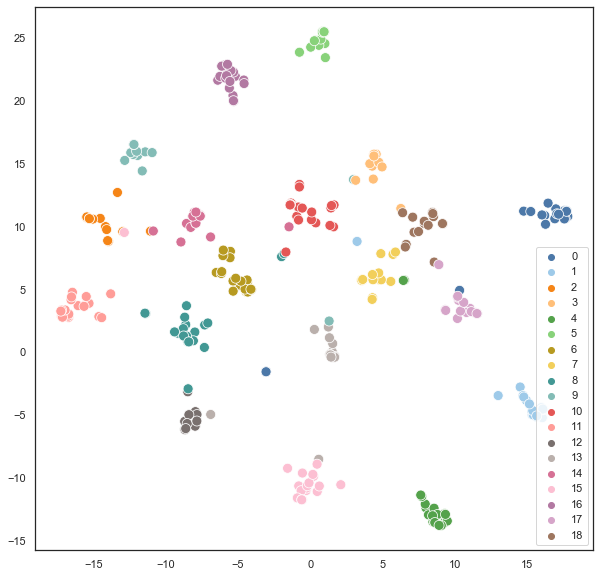

In [276]:
#VIS

import seaborn as sns

colors = ["#4c78a8", "#9ecae9", "#f58517", "#ffbf79", "#54a24b", "#88d27a", "#b79a21", "#f2cf5b", "#429894", "#83bcb6", "#e45756", "#ff9d98", "#79706e", "#bab0ac", "#d67195", "#fcbfd2", "#b279a2", "#d6a5c9", "#9e765f"]
# colors = sns.color_palette("bright", 6)

sns.set(rc={'figure.figsize':(10,10)})
sns.set_style("white")

# sns.set_palette(sns.color_palette(colors))

sns.scatterplot(tsne_lda[:,0], tsne_lda[:,1], hue=doc_wise_topic, legend='full', palette=colors, s=100)

In [288]:
tsne_df = pd.DataFrame(columns=['comment', 'X', 'Y', 'dom_topic'])

tsne_df['comment'] = list(df['comment'])
tsne_df['X'] = tsne_lda[:, 0]
tsne_df['Y'] = tsne_lda[:, 1]
tsne_df['dom_topic'] = doc_wise_topic

tsne_df.to_json('cc_tsne.json', orient='records')

In [289]:
# unsupervised lda with mallet

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

In [290]:
# model generation

def create_dict_and_corpus(data_lemmatized):
    # Create Dictionary
    id2word = corpora.Dictionary(data_lemmatized)

    # Create Corpus
    texts = data_lemmatized

    # Term Document Frequency
    corpus = [id2word.doc2bow(text) for text in texts]

    # # Human readable format of corpus (term-frequency)
    # [[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]
    
    return id2word, corpus

# create lda model (mallet)
def create_mallet_lda_model(id2word, corpus):
    # # Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
    import os
    os.environ.update({'MALLET_HOME': r'/home/mjasim/Matryona/topic_modeling/mallet/'})
    mallet_path = '/home/mjasim/Matryona/topic_modeling/mallet/bin/mallet'
    ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=10, id2word=id2word)
    
    return ldamallet

In [291]:
# Compute Coherence Score
def get_coherence_score(ldamallet, data_lemmatized, id2word):
    coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
    coherence_ldamallet = coherence_model_ldamallet.get_coherence()
    return coherence_ldamallet

In [292]:
# get optimal number of topics

def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    
    mallet_path = '/home/mjasim/Matryona/topic_modeling/mallet/bin/mallet'
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)        
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [293]:
# find the best model
def get_best_model(model_list, coherence_values, start, limit, step):
    max = 0
    num_topics = 0
    list_idx = 0
    result = []
    x = range(start, limit, step)
    for m, cv in zip(x, coherence_values):
#         print("Num Topics =", m, " has Coherence Value of", round(cv, 4))
        if(cv > max):
            max = cv
            num_topics = m
            model_idx = list_idx
        list_idx += 1

    # Select the best model
    optimal_model = model_list[model_idx]
    
    return optimal_model

In [294]:
data_lemmatized = list(df['lemmatize_token'])
id2word, corpus = create_dict_and_corpus(data_lemmatized)
ldamallet = create_mallet_lda_model(id2word, corpus)
coherence_ldamallet = get_coherence_score(ldamallet, data_lemmatized, id2word)
start = 2
limit = 15
step = 2
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=start, limit=limit, step=step)
optimal_model = get_best_model(model_list, coherence_values, start, limit, step)

INFO:gensim.corpora.dictionary:adding document #0 to Dictionary(0 unique tokens: [])
INFO:gensim.corpora.dictionary:built Dictionary(1180 unique tokens: ['audio', 'california', 'chime', 'component', 'emanate']...) from 344 documents (total 3084 corpus positions)
INFO:gensim.models.wrappers.ldamallet:serializing temporary corpus to /tmp/87d4e8_corpus.txt
INFO:gensim.models.wrappers.ldamallet:converting temporary corpus to MALLET format with /home/mjasim/Matryona/topic_modeling/mallet/bin/mallet import-file --preserve-case --keep-sequence --remove-stopwords --token-regex "\S+" --input /tmp/87d4e8_corpus.txt --output /tmp/87d4e8_corpus.mallet
INFO:gensim.models.wrappers.ldamallet:training MALLET LDA with /home/mjasim/Matryona/topic_modeling/mallet/bin/mallet train-topics --input /tmp/87d4e8_corpus.mallet --num-topics 10  --alpha 50 --optimize-interval 0 --num-threads 4 --output-state /tmp/87d4e8_state.mallet.gz --output-doc-topics /tmp/87d4e8_doctopics.txt --output-topic-keys /tmp/87d4e8_

INFO:gensim.topic_coherence.text_analysis:accumulator serialized
INFO:gensim.topic_coherence.text_analysis:accumulator serialized
INFO:gensim.topic_coherence.text_analysis:serializing accumulator to return to master...
INFO:gensim.topic_coherence.text_analysis:serializing accumulator to return to master...
INFO:gensim.topic_coherence.text_analysis:serializing accumulator to return to master...
INFO:gensim.topic_coherence.text_analysis:accumulator serialized
INFO:gensim.topic_coherence.text_analysis:accumulator serialized
INFO:gensim.topic_coherence.text_analysis:accumulator serialized
INFO:gensim.topic_coherence.text_analysis:accumulator serialized
INFO:gensim.topic_coherence.text_analysis:serializing accumulator to return to master...
INFO:gensim.topic_coherence.text_analysis:accumulator serialized
INFO:gensim.topic_coherence.text_analysis:11 accumulators retrieved from output queue
INFO:gensim.topic_coherence.text_analysis:accumulated word occurrence stats for 267 virtual documents
I

INFO:gensim.topic_coherence.text_analysis:serializing accumulator to return to master...
INFO:gensim.topic_coherence.text_analysis:serializing accumulator to return to master...
INFO:gensim.topic_coherence.text_analysis:serializing accumulator to return to master...
INFO:gensim.topic_coherence.text_analysis:serializing accumulator to return to master...
INFO:gensim.topic_coherence.text_analysis:serializing accumulator to return to master...
INFO:gensim.topic_coherence.text_analysis:accumulator serialized
INFO:gensim.topic_coherence.text_analysis:accumulator serialized
INFO:gensim.topic_coherence.text_analysis:accumulator serialized
INFO:gensim.topic_coherence.text_analysis:accumulator serialized
INFO:gensim.topic_coherence.text_analysis:serializing accumulator to return to master...
INFO:gensim.topic_coherence.text_analysis:accumulator serialized
INFO:gensim.topic_coherence.text_analysis:accumulator serialized
INFO:gensim.topic_coherence.text_analysis:accumulator serialized
INFO:gensim

In [295]:
# get topic keywords to guiding

import re

topic_keywords = []

for idx, topic in optimal_model.print_topics(-1):
    topic_keywords.append(re.findall(r'"(.*?)"', topic))

INFO:gensim.models.wrappers.ldamallet:topic #0 (3.571): 0.064*"place" + 0.058*"good" + 0.047*"work" + 0.029*"full" + 0.023*"private" + 0.023*"light" + 0.023*"effective" + 0.023*"positive" + 0.017*"offer" + 0.017*"horton"
INFO:gensim.models.wrappers.ldamallet:topic #1 (3.571): 0.170*"traffic" + 0.150*"pedestrian" + 0.065*"motor" + 0.040*"safe" + 0.035*"center" + 0.020*"store" + 0.020*"free" + 0.020*"point" + 0.015*"comfortable" + 0.015*"sit"
INFO:gensim.models.wrappers.ldamallet:topic #2 (3.571): 0.158*"people" + 0.148*"homeless" + 0.049*"bring" + 0.038*"visit" + 0.027*"due" + 0.027*"vehicle" + 0.022*"future" + 0.016*"built" + 0.016*"necessity" + 0.011*"survey"
INFO:gensim.models.wrappers.ldamallet:topic #3 (3.571): 0.098*"great" + 0.087*"street" + 0.071*"roundabout" + 0.044*"green" + 0.044*"provide" + 0.038*"intersection" + 0.038*"monument" + 0.033*"increase" + 0.033*"place" + 0.027*"open"
INFO:gensim.models.wrappers.ldamallet:topic #4 (3.571): 0.077*"transit" + 0.060*"trolley" + 0.060

In [254]:
# guided lda again with seeds from unsupervised lda

INFO:guidedlda:n_documents: 344
INFO:guidedlda:vocab_size: 1180
INFO:guidedlda:n_words: 3084
INFO:guidedlda:n_topics: 14
INFO:guidedlda:n_iter: 500
INFO:guidedlda:<0> log likelihood: -40545
INFO:guidedlda:<20> log likelihood: -25150
INFO:guidedlda:<40> log likelihood: -24641
INFO:guidedlda:<60> log likelihood: -24366
INFO:guidedlda:<80> log likelihood: -24244
INFO:guidedlda:<100> log likelihood: -24148
INFO:guidedlda:<120> log likelihood: -24174
INFO:guidedlda:<140> log likelihood: -24155
INFO:guidedlda:<160> log likelihood: -24203
INFO:guidedlda:<180> log likelihood: -24145
INFO:guidedlda:<200> log likelihood: -24104
INFO:guidedlda:<220> log likelihood: -24092
INFO:guidedlda:<240> log likelihood: -24040
INFO:guidedlda:<260> log likelihood: -24101
INFO:guidedlda:<280> log likelihood: -24120
INFO:guidedlda:<300> log likelihood: -24004
INFO:guidedlda:<320> log likelihood: -24014
INFO:guidedlda:<340> log likelihood: -24130
INFO:guidedlda:<360> log likelihood: -24018
INFO:guidedlda:<380> l

Topic 0: bridge neighborhood entire make important ada next fact much little
Topic 1: traffic motor dog space feasible pedestrian roundabout private street promenade
Topic 2: city see like people one feel park need small put
Topic 3: street great homeless building walk clean safe absolutely paint money
Topic 4: homeless become one also create security current attraction every sure
Topic 5: project feasible work future bike may community design believe plan
Topic 6: tower yes city structure two nudillo built element incorporate whatever
Topic 7: barrio impact create east village life bring community logan quality
Topic 8: good art enough get tower neutral concept like sound solution
Topic 9: pedestrian bus trolley hub love street traffic space restaurant transit
Topic 10: fountain water san homeless diego another need city help safety
Topic 11: people transit take car community walk public live encourage run
Topic 12: park public art resident market great activity plaza need also
Topic 

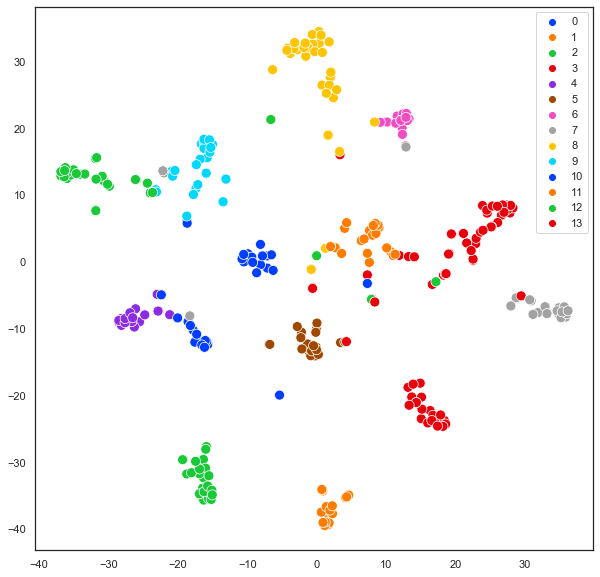

In [300]:
n_topics = idx + 1
# n_topics = 6

model = guidedlda.GuidedLDA(n_topics=n_topics, n_iter=500, random_state=7, refresh=20)
seed_topics = {}
for t_id, st in enumerate(topic_keywords):
    for word in st:
        seed_topics[word2id[word]] = t_id
model.fit(X, seed_topics=seed_topics, seed_confidence=0.15)

n_top_words = 10
topic_word = model.topic_word_
for i, topic_dist in enumerate(topic_word):
     topic_words = np.array(tf_feature_names)[np.argsort(topic_dist)][:-(n_top_words+1):-1]
     print('Topic {}: {}'.format(i, ' '.join(topic_words)))
    
doc_topic = model.transform(X)
doc_wise_topic = []
for i in range(0, len(doc_topic)):
    doc_wise_topic.append(doc_topic[i].argmax())
    
tsne_model = TSNE(n_components = 2, perplexity=10, verbose = 1, random_state = 7, angle = .99, init = 'pca')
tsne_lda = tsne_model.fit_transform(doc_topic)

# colors = ["#4c78a8", "#9ecae9", "#f58517", "#ffbf79", "#54a24b", "#88d27a", "#b79a21", "#f2cf5b", "#429894", "#83bcb6", "#e45756", "#ff9d98", "#79706e", "#bab0ac", "#d67195", "#fcbfd2", "#b279a2", "#d6a5c9", "#9e765f"]
colors = sns.color_palette("bright", n_colors=n_topics)

sns.set(rc={'figure.figsize':(10,10)})
sns.set_style("white")

# sns.set_palette(sns.color_palette(colors))

sns.scatterplot(tsne_lda[:,0], tsne_lda[:,1], hue=doc_wise_topic, legend='full', palette=colors, s=100)

In [301]:
tsne_df = pd.DataFrame(columns=['comment', 'X', 'Y', 'dom_topic'])

tsne_df['comment'] = list(df['comment'])
tsne_df['X'] = tsne_lda[:, 0]
tsne_df['Y'] = tsne_lda[:, 1]
tsne_df['dom_topic'] = doc_wise_topic

tsne_df.to_json('cc_tsne.json', orient='records')

In [302]:
tsne_df

,comment,X,Y,dom_topic
0,A structure or monument at the Nudillo could i...,11.594522,21.810265,6
1,The built form should be lit at night.,12.449378,22.135103,6
2,"More than a plaza, the space can be activated ...",-29.869177,11.308897,12
3,The structure could incorporate an observation...,12.924546,22.198175,6
4,I think its a great idea,8.016350,-5.576012,3
...,...,...,...,...
339,"Depends on the location, and the activity of t...",-36.304958,13.655338,12
340,not sure,-24.758261,-7.949684,4
341,Suggest to work with the East Village Associat...,-0.124003,-10.560569,5
342,This is a great idea to activate the area and ...,17.415888,-24.603189,3


In [309]:
# topic_wise coordinates 

def reject_outliers(data, m=2.):
    d = np.abs(data - np.median(data))
    mdev = np.median(d)
    s = d / (mdev if mdev else 1.)
    return data[s < m]

def centeroidnp(arr):
    length = arr.shape[0]
    sum_x = np.sum(arr[:, 0])
    sum_y = np.sum(arr[:, 1])
    return sum_x/length, sum_y/length

topics = tsne_df.dom_topic.unique()
centroid_data = []
for t in topics:
    coord = []
    topic_wise_coords_X = (list(tsne_df.loc[tsne_df['dom_topic'] == t, 'X']))
    topic_wise_coords_Y = (list(tsne_df.loc[tsne_df['dom_topic'] == t, 'Y']))
    
    for i in range (len(topic_wise_coords_X)):
        c = [topic_wise_coords_X[i], topic_wise_coords_Y[i]]
        coord.append(c)
        
        

[[6 3]
 [7 4]
 [6 9]
 ...
 [8 8]
 [9 7]
 [6 4]]
